In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn

def log_sum_exp(tensor, dim=-1, sum_op=torch.sum):
    """
    Uses the LogSumExp (LSE) as an approximation for the sum in a log-domain.
    :param tensor: Tensor to compute LSE over
    :param dim: dimension to perform operation over
    :param sum_op: reductive operation to be applied, e.g. torch.sum or torch.mean
    :return: LSE
    """
    max, _ = torch.max(tensor, dim=dim, keepdim=True)
    return torch.log(sum_op(torch.exp(tensor - max), dim=dim, keepdim=True) + 1e-8) + max

### $N$-dimensional features, scalar regression target, No covariance

### Problem

We consider a egression problem with N-dimensional features $x$, scalar targets $t$ and known variance $\sigma^2$ We wish to learn a bayesian linear model with learnt basis functions. 

### Case of the known basis function

In the case of a known deterministic N-dimensional basis function $\phi$, le likelihood is expressed as:

\begin{align}
p(t | a, b, x, \sigma) & = \mathcal{N}(a \phi(x) + b, \sigma^2) 
\end{align}

We define the prior over the parameters as an isotropic Gaussian, which gives:

\begin{align}
 p(a) = \mathcal{N}(0,1) \qquad  p(b) = \mathcal{N}(0,1)
\end{align}

It is then possible to compute the posterior of parameters analytically, given $(\mathbf{x}, \mathbf{t})$ the entire dataset:

\begin{align}
p(a,b |\mathbf{t} , \mathbf{x}, \sigma^2) = \frac{p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2) p(a,b)}{p(\mathbf{t}, \mathbf{x})}
\end{align}

$p(\mathbf{t})$ is tractable and constant, hence we can also approximate the posterior using our favorite MCMC methods.


### Learnt basis function

#### Bayes by Backprop

We propose to optimize $\theta$ using maximum likelihood and $a, b$ using Variational Inference, which allows us deriving a lower bound of the marginal log likelihood (with regards to $a,b$) that we can optimize end-to-end. We have:

\begin{align}
\log p(\mathbf{t} | \mathbf{x}, \sigma^2, \theta) & = \log \int_{a,b} \log p(\mathbf{t}, a, b, | \mathbf{x}, \sigma^2, \theta) dadb \\
& = \log \int_{a,b} \log p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2, \theta)p(a,b) dadb \\
& = \log \int_{a,b} q(a,b) p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2, \theta) \frac{p(a,b)}{q(a,b)} dadb \\
& \geq \mathbb{E}_{q(a,b)} \left[ \log  p(\mathbf{t} | a, b, \mathbf{t}, \sigma^2, \theta) \frac{p(a,b)}{q(a,b)} \right] \\
& = \mathbb{E}_q[\log p_{\theta}(\mathbf{t}\ |\ a, b, \mathbf{x})] - \mathrm{KL}(q(a,b) \ ||\ p(a,b)) \\
= \mathcal{L_(t, x)}
\end{align}

#### Modelling the posterior of vector quantities

In this context, $a$ is a vector of size $N$ and $b$ a scalar. We write $v$ the vector representing all the parameters ${a_i}_a + b$. In this context, we choose to model the approximate posterior of $v$ using a diagonal Gaussian.

We can then write our ELBO as:

\begin{split}
\mathbb{E}_q[\log p_{\theta}(\mathbf{t}\ |\ a, b, \mathbf{x})] =  \mathbb{E}_q \left[ \sum_{x \in \mathbf{x}} \left[ -\frac{1}{2} \log \sigma^2 - \frac{1}{2\sigma^2} [(t - a f_{\theta}(x) - b)^2] + \mathrm{const.} \right] \right] \\
\mathrm{KL}(q(a,b) \ ||\ p(a,b)) = -\frac{1}{2} \sum_{i\in v} \left(1 + \log \sigma_i^2 - \mu_i^2 - \sigma_i^2\right)
\end{split}



#### Toy Dataset 1

f shape: (200, 3)
a shape: (3, 1)


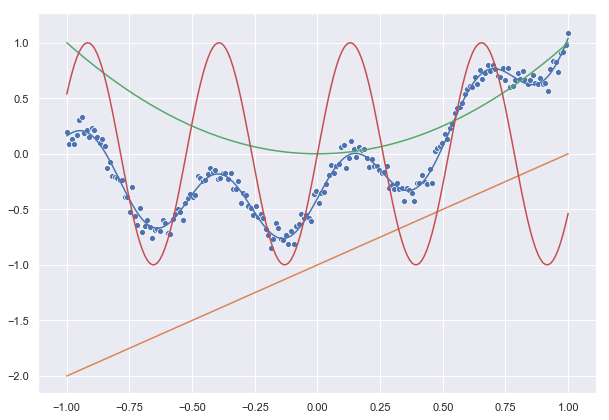

In [2]:
N = 200
true_a = np.array([0.6, 1, .3]).reshape(-1, 1)
true_b = np.asarray(0.2)
sigma = 0.06  # observation noise
x = np.linspace(-1, 1, N).reshape(-1, 1)
fx1 = x - 1
fx2 = x**2
fx3 = np.sin(12 * x)
fx = np.concatenate((fx1, fx2, fx3), axis=-1)
print('f shape:', fx.shape)
print('a shape:', true_a.shape)
t = fx @ true_a + true_b + sigma*np.random.randn(*x.shape)  # observations
plt.figure(figsize=(10, 7))
plt.plot(x, fx @ true_a + true_b)
plt.plot(x, fx)
sns.scatterplot(x[:, 0], t[:, 0])
plt.show() 

x = torch.tensor(x, dtype=torch.float)
t = torch.tensor(t, dtype=torch.float)

#### Features extractor and stochastic layer

Define function $f_{\theta}$ to extract features $h = f_{\theta}(x)$, with parameters $\theta$ to be optimized.

The stochastic layer has no state, it's only used to get samples from $\mathcal{N}(\mu, \sigma^2)$, and to compute the KL divergence from a prior $\mathcal{N}(0, 1)$ to a variational distribution $q = \mathcal{N}(\mu, \sigma^2)$.

In [3]:
class FeaturesExtractor(nn.Module):
    def __init__(self, n_out):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32), nn.ReLU(),
            nn.Linear(32, n_out))
        
    def forward(self, x):
        return self.layers(x)
    
    
class StochasticLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_q, logvar_q):
        eps = torch.randn_like(mu_q)
        std = (logvar_q/2).exp()
        return mu_q + std * eps

    def get_kl(self, mu_q, logvar_q):
        """KL from standard normal. Independent variables, shape is irrelevant, KL is summed over all dimensions."""
        kl = -0.5 * (1 + logvar_q - mu_q.pow(2) - logvar_q.exp())
        return kl.sum()


### Optimize

Here we maximize the ELBO $\mathcal{L}$ with respect to variational parameters $\mu_a, \sigma_a, \mu_b, \sigma_b$, the NN parameters $\theta$, and the noise std $\sigma$.

In [4]:
features = FeaturesExtractor(n_out=true_a.shape[0])
stochastic = StochasticLayer()
l_rate = 0.01
epochs = 10000
n_samples = 10  # MC samples per example
mu_ab = nn.Parameter(torch.zeros((true_a.size + true_b.size)))  # for a and b
logvar_ab = nn.Parameter(torch.zeros((true_a.size + true_b.size)))  # for a and b
logvar = nn.Parameter(torch.tensor(0.))  # for noise
optimiser = torch.optim.Adam(list(features.parameters()) + [mu_ab, logvar_ab, logvar], lr = l_rate)

for epoch in range(epochs):
    optimiser.zero_grad()
    h = features(x)
    elbo = torch.zeros((n_samples), device=x.device)
    for i in range(n_samples):
        ## Sample once from q(a) q(b)
        ab_sample = stochastic(mu_ab, logvar_ab)
        a, b = ab_sample[:-1], ab_sample[-1:]
        a = a.unsqueeze(1)
        b = b.unsqueeze(1)
        
        y = h @ a + b  # stochasticity here only comes from a and b
        expected_mse_i = (t - y)**2
    
        ## Reconstruction loss, estimated by MC
        recons_i = (0.5/logvar.exp() * expected_mse_i + 0.5*logvar).sum()  # recons per sample
    
        # KL term
        kl_i = stochastic.get_kl(mu_ab, logvar_ab)
    
        elbo[i] = - recons_i - kl_i
        
    # IW averaging (KL doesn't grow with IW)
    # elbo = log_sum_exp(elbo, dim=0, sum_op=torch.mean)
    
    elbo = elbo.mean()
    
    loss = - elbo
    loss.backward()
    optimiser.step()
    if epoch % 250 == 0 or epoch == epochs-1:
        print(f'epoch {epoch} : loss {loss.data.item():.3f} ELBO {elbo.data.item():.3f}  Reconstruction {recons_i.mean().data.item()}  KL {kl_i.mean().data.item()}')

epoch 0 : loss 129.027 ELBO -129.027  Reconstruction 169.99105834960938  KL 0.0
epoch 250 : loss -81.624 ELBO 81.624  Reconstruction -96.41777038574219  KL 2.766110420227051
epoch 500 : loss -130.885 ELBO 130.885  Reconstruction 197.0343475341797  KL 5.321751594543457
epoch 750 : loss -210.203 ELBO 210.203  Reconstruction -214.50648498535156  KL 6.812002658843994
epoch 1000 : loss -224.911 ELBO 224.911  Reconstruction -233.2025604248047  KL 8.026557922363281
epoch 1250 : loss -244.992 ELBO 244.992  Reconstruction -263.0251770019531  KL 9.291379928588867
epoch 1500 : loss -273.519 ELBO 273.519  Reconstruction -288.7400817871094  KL 11.530195236206055
epoch 1750 : loss -278.036 ELBO 278.036  Reconstruction -291.5694580078125  KL 12.414319038391113
epoch 2000 : loss -281.870 ELBO 281.870  Reconstruction -292.393310546875  KL 12.622886657714844
epoch 2250 : loss -279.766 ELBO 279.766  Reconstruction -297.4485168457031  KL 12.85617446899414
epoch 2500 : loss -282.415 ELBO 282.415  Reconstru

### Visualization

First we sample $a,b \sim q(a,b)$ according to the learned variational parameters. Get $N$ samples $a_i$ and $b_i$. Then sample from predictive distribution
$$t_i = a_i f_{\theta}(x_i) + b_i + \sigma \epsilon_i$$
with $\epsilon_i$ iid samples from $\mathcal{N}(0,1)$.

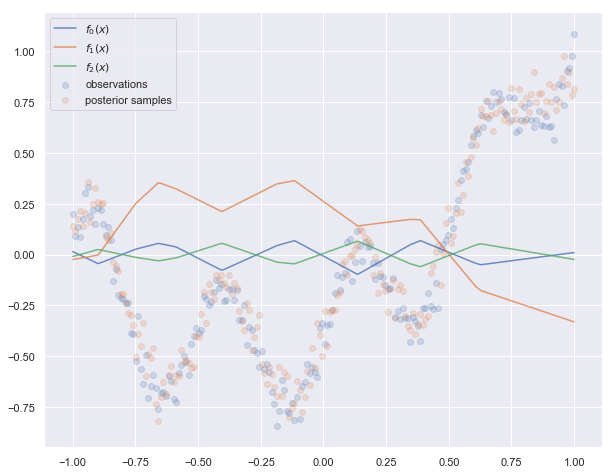

In [5]:
# Get parameters of q(a) and q(b)
mu_a, mu_b = mu_ab[:-1], mu_ab[-1:]
logvar_a, logvar_b = logvar_ab[:-1], logvar_ab[-1:]
mu_a_ = mu_a.detach().numpy()
mu_b_ = mu_b.detach().numpy()
std_a = (logvar_a/2).exp().detach().numpy()
std_b = (logvar_b/2).exp().detach().numpy()

# Sample a, b ~ q(a, b)
n_samples = t.shape[0]
a = np.random.multivariate_normal(mu_a_.flatten(), np.diag(std_a.flatten()**2), n_samples)
a = np.expand_dims(a, -1)
b = np.random.randn(n_samples) * std_b + mu_b_

# plt.figure(figsize=(6, 6))
# plt.pcolor
# plt.scatter(a, b, s=5)
# plt.xlabel('a')
# plt.ylabel('b')
# plt.title('samples from q(a, b)')
# plt.gca().set_aspect('equal', 'datalim')  # equal aspect ratio
# plt.show()

# For each x_i, use samples a_i, b_i to compute predicted t_i
h_ = features(x).detach().numpy()
# Do weird shape stuff because now we have many samples of a and b (unlike during training)
post_samples = (np.expand_dims(h_, 1) @ a).flatten() + b.flatten() + (logvar/2).exp().detach().numpy() * np.random.randn(n_samples)
plt.figure(figsize=(10,8))
plt.scatter(x, t, alpha=0.2, label='observations')
plt.scatter(x, post_samples, alpha=0.2, label='posterior samples')
for i in range(h.shape[1]):
    plt.plot(x.numpy(), h_[:, i], alpha=0.8, label='$f_{}(x)$'.format(i))
# plt.plot(x.numpy(), p5.numpy(), '--', color=sns.color_palette()[1], label='95% posterior interval')
# plt.plot(x.numpy(), p95.numpy(), '--',color=sns.color_palette()[1])
plt.legend()
plt.show()